In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

In [2]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 9426017
r_scale = 200.0

I_data = np.array( ( who_data.iloc[:,0]) / N )
R_data = np.array( ( who_data.iloc[:,1]*r_scale ) / N )
D_data = np.array( ( who_data.iloc[:,1]) / N )
S_data = np.array( 1 - I_data - R_data - D_data )

times = who_data.iloc[:,2]

I0 = I_data[0]
R0 = R_data[0]
S0 = S_data[0]
D0 = D_data[0]
W0 = 0.0

### Basic SIRD Model

In [3]:
def SIRD_model(y,t,alpha,beta, mu, c, h):
    S, I, R, D = y
    dSdt = -(beta)*S*I - h*D
    dIdt = (beta)*S*I- alpha*I - mu*I + h*D
    dRdt = alpha*I 
    dDdt = mu*I 
    
    return dSdt, dIdt, dRdt, dDdt

In [4]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
h = 0.1
c = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 17
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days], D_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, c, h = params['alpha'].value, params['beta'].value, params['mu'].value, params['c'].value, params['h'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, c, h)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 37.114080981194583
    print((10-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)
params.add('c', value=c, min=0, max=10)
params.add('h', value=h, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')



AIC SCORE:
9.835149670087294
AIC SCORE:
9.835149670087294
AIC SCORE:
9.835149670087294
AIC SCORE:
9.835151831594832
AIC SCORE:
9.83514740922868
AIC SCORE:
9.835148262769613
AIC SCORE:
9.835149670087294
AIC SCORE:
9.835146091678528
AIC SCORE:
14.083622789397545
AIC SCORE:
14.08362517785335
AIC SCORE:
14.083620159828783
AIC SCORE:
14.083621512390252
AIC SCORE:
14.083622789397545
AIC SCORE:
14.083618732194967
AIC SCORE:
17.356284256609015
AIC SCORE:
17.356286355137517
AIC SCORE:
17.356282369348573
AIC SCORE:
17.35628206185553
AIC SCORE:
17.356284256609015
AIC SCORE:
17.356280339158104
AIC SCORE:
18.86093520853712
AIC SCORE:
18.86093707856231
AIC SCORE:
18.860934890019344
AIC SCORE:
18.860931453952862
AIC SCORE:
18.86093520853712
AIC SCORE:
18.86093184675838
AIC SCORE:
15.784733185330392
AIC SCORE:
23.32461038074853
AIC SCORE:
23.324612469838534
AIC SCORE:
23.32460998793387
AIC SCORE:
23.324605478490646
AIC SCORE:
23.32461038074853
AIC SCORE:
23.32460700935468
AIC SCORE:
30.4168378756122
A

In [5]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta,"\nc =", c, "\nh =", h, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta,  mu, c, h)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.009876651642499179 
beta = 0.01486170637091 
c = 0.10000000000000009 
h = 1.3289015062284115 
mu = 0.0004246776484956305


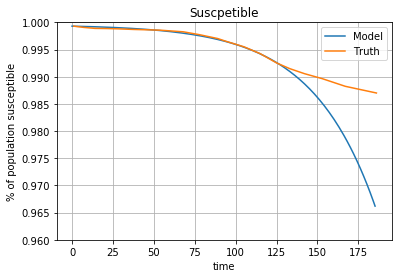

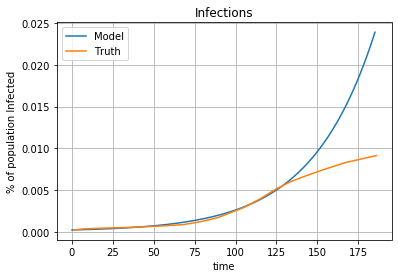

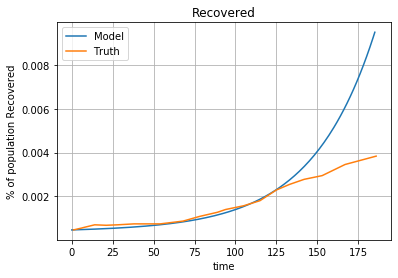

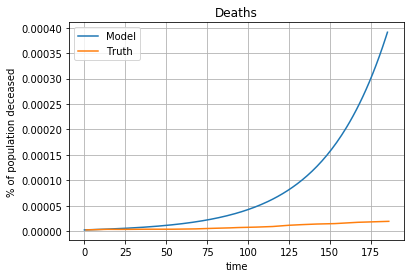

In [6]:


# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.960,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


## Improved Model

In [7]:
def SIRD_model(y,t,alpha,beta, beta2, mu, c, h, w_1, w_2, phi, theta):
    S, I, R, D = y
    dSdt = (-beta*S*I) + (theta*S*I) - (c*S*R) - (h*D) + (beta2*I) - phi*(S*I+I*R)
    dIdt = (beta*S*I) - (theta*S*I) - (w_1*alpha*I + w_2*I) - (mu*I) + (c*S*R) + (h*D) - (beta2*I) + phi*(S*I+I*R)
    dRdt = (w_1*alpha*I + w_2*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [8]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1
h = 0.1
c = 0.1
phi = 0.1
w_1 = 0.1
w_2 = 0.1
theta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta = params['alpha'].value, params['beta'].value, params['beta2'].value, params['mu'].value, params['c'].value, params['h'].value, params['w_1'].value, params['w_2'].value, params['phi'].value, params['theta'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 43.732673523272894
    print((20-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('c', value=c, min=0, max=10)
params.add('h', value=h, min=0, max=10)
params.add('w_1', value=w_1, min=1, max=10)
params.add('w_2', value=w_2, min=0, max=10)
params.add('phi', value=phi, min=0, max=10)
params.add('theta', value=theta, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

AIC SCORE:
13.679787742843821
AIC SCORE:
13.679787742843821
AIC SCORE:
13.679787742843821
AIC SCORE:
13.679787794403751
AIC SCORE:
13.679787627581238
AIC SCORE:
13.679787905383666
AIC SCORE:
13.679787694513099
AIC SCORE:
13.679787575402175
AIC SCORE:
13.679787328637696
AIC SCORE:
13.67978774284381
AIC SCORE:
13.679787794403751
AIC SCORE:
13.679787599304522
AIC SCORE:
13.679787858106408
AIC SCORE:
12.51041042930036
AIC SCORE:
12.507979712926499
AIC SCORE:
12.165304349798687
AIC SCORE:
12.667798894603644
AIC SCORE:
-33.01395706876383
AIC SCORE:
13.712540110233915
AIC SCORE:
13.712540063121038
AIC SCORE:
13.712540094091578
AIC SCORE:
13.712540143387326
AIC SCORE:
13.712540114425394
AIC SCORE:
13.71254008066365
AIC SCORE:
13.712540054290846
AIC SCORE:
13.71344983222684
AIC SCORE:
13.712540075533132
AIC SCORE:
13.71254014906076
AIC SCORE:
13.712540125953883
AIC SCORE:
14.20017764979493
AIC SCORE:
14.200177545886312
AIC SCORE:
14.200177626050982
AIC SCORE:
14.200177704001131


C:\Users\dusan\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


AIC SCORE:
14.200177659938593
AIC SCORE:
14.200177594948418
AIC SCORE:
14.200177688468925
AIC SCORE:
14.200998099269547
AIC SCORE:
14.200177553412782
AIC SCORE:
14.200177701160946
AIC SCORE:
14.200177673497677
AIC SCORE:
15.151750383507256
AIC SCORE:
15.15174987156023
AIC SCORE:
15.151750246822207
AIC SCORE:
15.151750636331446
AIC SCORE:
15.151750361290858
AIC SCORE:
15.151750235965082
AIC SCORE:
15.15175027216357
AIC SCORE:
15.14850251521171
AIC SCORE:
15.151749964703967
AIC SCORE:
15.151750608959038
AIC SCORE:
15.15175045118647
AIC SCORE:
14.873050685872238
AIC SCORE:
15.655401776848976
AIC SCORE:
15.655400688584997
AIC SCORE:
15.655401556808059
AIC SCORE:
15.655402112852295
AIC SCORE:
15.655401808987701
AIC SCORE:
15.655401669996651
AIC SCORE:
15.65540178201361
AIC SCORE:
15.662215948430891
AIC SCORE:
15.655401263822291
AIC SCORE:
15.655402099717156
AIC SCORE:
15.655401809756901
AIC SCORE:
18.414685134718148
AIC SCORE:
18.414683819950145
AIC SCORE:
18.414684743284052
AIC SCORE:
18.4

In [9]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value
w_1 = result.params['w_1'].value
w_2 = result.params['w_2'].value
phi = result.params['phi'].value
theta = result.params['theta'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nbeta2 =", beta2,"\nc =", c, "\nh =", h, "\nmu =", mu , "\nw_1 =", w_1, "\nw_2 =", w_2 , "\nphi =", phi , "\ntheta =", theta )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2, mu, c, h, w_1, w_2, phi, theta  )))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.005497199841737466 
beta = 1.9040040720934854 
beta2 = 1.9400877547771893 
c = 2.912946434063812e-07 
h = 0.020194941172014258 
mu = 2.282158088207087e-05 
w_1 = 1.0391330230570053 
w_2 = 0.0004838884307567515 
phi = 0.07237374635788274 
theta = 0.00015862344484807167


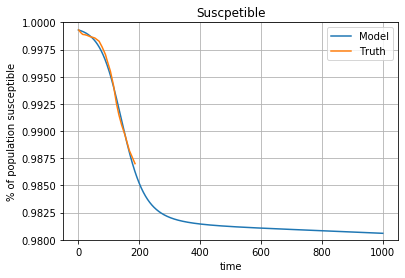

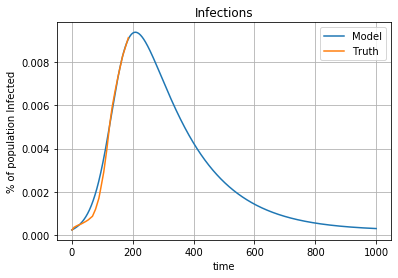

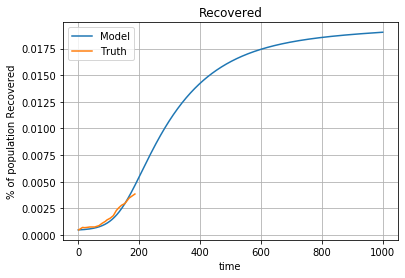

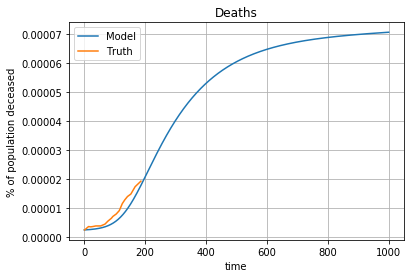

In [10]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:1000], S_model[0:1000], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:1000], I_model[0:1000], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:1000], R_model[0:1000], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:1000], D_model[0:1000], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism 1

In [11]:
def SIRD_model(y,t,alpha,beta, beta2, mu):
    S, I, R, D = y
    dSdt = (-beta*S*I) - (c*S*R) - (h*D) + (beta2*I) 
    dIdt = (beta*S*I)  - (alpha*I) - (mu*I) + (c*S*R) + (h*D) - (beta2*I)
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [12]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, mu = params['alpha'].value, params['beta'].value, params['beta2'].value, params['mu'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, beta2, mu)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 40.320403573801606
    print((20-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

AIC SCORE:
34.05459610181181
AIC SCORE:
34.05459610181181
AIC SCORE:
34.05459610181181
AIC SCORE:
34.05459606538027
AIC SCORE:
34.05459617162032
AIC SCORE:
34.05459603194157
AIC SCORE:
34.05459614292425
AIC SCORE:
33.760737479744556
AIC SCORE:
13.379613422805981
AIC SCORE:
15.064720993639575
AIC SCORE:
34.76893962762411
AIC SCORE:
34.76893970652824
AIC SCORE:
34.76893967083227
AIC SCORE:
34.76893965693636
AIC SCORE:
34.768939624545204
AIC SCORE:
14.064363960812708
AIC SCORE:
35.022352279098534
AIC SCORE:
35.02235225734394
AIC SCORE:
35.02235228389235
AIC SCORE:
35.02235228153296
AIC SCORE:
35.02235230666547
AIC SCORE:
35.25951959860069
AIC SCORE:
35.25951968311984
AIC SCORE:
35.2595196422889
AIC SCORE:
35.259519618556254
AIC SCORE:
35.259519617323036
AIC SCORE:
35.248161909651216
AIC SCORE:
35.31792063104907
AIC SCORE:
35.31792065628835
AIC SCORE:
35.31792063898145
AIC SCORE:
35.3179206355644
AIC SCORE:
35.317920625300985
AIC SCORE:
35.31972799741847
AIC SCORE:
35.31972810354209
AIC SC

In [13]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
mu = result.params['mu'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nbeta2 =", beta2, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2, mu)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.007965464145754386 
beta = 0.6323804596484467 
beta2 = 0.6005787747809799 
mu = 6.641468530688144e-07


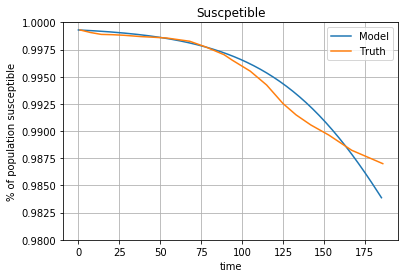

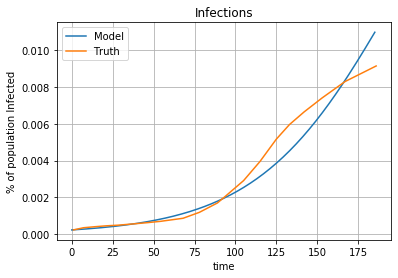

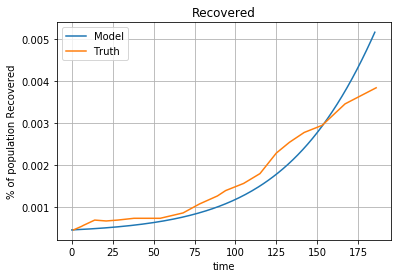

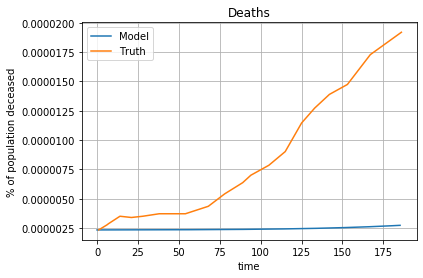

In [14]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #2

In [15]:
def SIRD_model(y,t,alpha,beta, mu, w_1, w_2):
    S, I, R, D = y
    dSdt = (-beta*S*I) - (c*S*R) - (h*D)
    dIdt = (beta*S*I)  - (w_1*alpha*I + w_2*I) - (mu*I) + (c*S*R) + (h*D) 
    dRdt = (w_1*alpha*I + w_2*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [16]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
w_1 = 0.1
w_2 = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, w_1, w_2 = params['alpha'].value, params['beta'].value, params['mu'].value, params['w_1'].value, params['w_2'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, w_1, w_2)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 35.21533599779585
    print((20-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('w_1', value=w_1, min=1, max=10)
params.add('w_2', value=w_2, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

AIC SCORE:
34.21701429890373
AIC SCORE:
34.21701429890373
AIC SCORE:
34.21701429890373
AIC SCORE:
34.21701422619675
AIC SCORE:
34.217014404140116
AIC SCORE:
34.21701430882804
AIC SCORE:
34.21701429890244
AIC SCORE:
34.21701422619675
AIC SCORE:
33.48146349832891
AIC SCORE:
34.98507285208844
AIC SCORE:
34.98507068723683
AIC SCORE:
34.985072635203196
AIC SCORE:
34.98507285095701
AIC SCORE:
34.984711339464646
AIC SCORE:
34.985071433783816
AIC SCORE:
33.84784342265035
AIC SCORE:
34.721353186810276
AIC SCORE:
34.27182198232383
AIC SCORE:
34.35725707834764
AIC SCORE:
35.044996185225195
AIC SCORE:
35.0449959680492
AIC SCORE:
35.0449961567189
AIC SCORE:
35.04499618873752
AIC SCORE:
35.044956676500526
AIC SCORE:
35.04499603223551
AIC SCORE:
35.03134430607346
AIC SCORE:
35.04729768144546
AIC SCORE:
35.04729768766312
AIC SCORE:
35.047297676232816
AIC SCORE:
35.04729768033855
AIC SCORE:
35.04729844742478
AIC SCORE:
35.047297685836895
AIC SCORE:
35.047912766574896
AIC SCORE:
35.04791279155384
AIC SC

AIC SCORE:
35.07729956184882
AIC SCORE:
35.07730179902764
AIC SCORE:
35.07729957334867
AIC SCORE:
35.07797761835818
AIC SCORE:
35.077977685268365
AIC SCORE:
35.07797761515806
AIC SCORE:
35.07797762021697
AIC SCORE:
35.07797979118315
AIC SCORE:
35.077977627588304
AIC SCORE:
35.07865382600528
AIC SCORE:
35.07865389293406
AIC SCORE:
35.0786538227158
AIC SCORE:
35.078653824206626
AIC SCORE:
35.07865588706206
AIC SCORE:
35.0786538348721
AIC SCORE:
35.079325522203305
AIC SCORE:
35.07932558949308
AIC SCORE:
35.07932551885746
AIC SCORE:
35.07932552401276
AIC SCORE:
35.07932751130409
AIC SCORE:
35.07932553075897
AIC SCORE:
35.07999511586158
AIC SCORE:
35.079995183996154
AIC SCORE:
35.07999511250686
AIC SCORE:
35.079995114058406
AIC SCORE:
35.079997049318514
AIC SCORE:
35.07999512417499
AIC SCORE:
35.080663153410306
AIC SCORE:
35.08066322244274
AIC SCORE:
35.08066315005283
AIC SCORE:
35.08066315522769
AIC SCORE:
35.08066503406101
AIC SCORE:
35.080663161493284
AIC SCORE:
35.08133018225187
AIC SCO

AIC SCORE:
35.10895064465426
AIC SCORE:
35.108950176641244
AIC SCORE:
35.10961181555133
AIC SCORE:
35.10961191262902
AIC SCORE:
35.10961181139863
AIC SCORE:
35.1096118172736
AIC SCORE:
35.10961226954762
AIC SCORE:
35.109611817306146
AIC SCORE:
35.11027404283213
AIC SCORE:
35.11027414047338
AIC SCORE:
35.11027403866351
AIC SCORE:
35.11027404112508
AIC SCORE:
35.110274481935676
AIC SCORE:
35.11027404452214
AIC SCORE:
35.110936996733145
AIC SCORE:
35.11093709476333
AIC SCORE:
35.11093699253108
AIC SCORE:
35.11093699844857
AIC SCORE:
35.110937420684245
AIC SCORE:
35.11093699835631
AIC SCORE:
35.11160022033006
AIC SCORE:
35.111600318993816
AIC SCORE:
35.11160021611768
AIC SCORE:
35.1116002186281
AIC SCORE:
35.11160063067016
AIC SCORE:
35.11160022189399
AIC SCORE:
35.112264100564204
AIC SCORE:
35.112264199665475
AIC SCORE:
35.11226409632525
AIC SCORE:
35.112264102273905
AIC SCORE:
35.11226449695298
AIC SCORE:
35.11226410206766
AIC SCORE:
35.1129283342554
AIC SCORE:
35.11292843387161
AIC SCOR

AIC SCORE:
35.14843375258658
AIC SCORE:
35.14843368954094
AIC SCORE:
35.14913809588134
AIC SCORE:
35.149138216068266
AIC SCORE:
35.14913809029816
AIC SCORE:
35.14913809738953
AIC SCORE:
35.149138156771514
AIC SCORE:
35.14913809602792
AIC SCORE:
35.14984290488672
AIC SCORE:
35.149843025597505
AIC SCORE:
35.14984289929582
AIC SCORE:
35.14984290339095
AIC SCORE:
35.14984296377622
AIC SCORE:
35.149842905026716
AIC SCORE:
35.15054817924173
AIC SCORE:
35.15054830062467
AIC SCORE:
35.15054817365434
AIC SCORE:
35.15054818074232
AIC SCORE:
35.15054823626722
AIC SCORE:
35.15054817937592
AIC SCORE:
35.15125506534447
AIC SCORE:
35.15125518655205
AIC SCORE:
35.151255059686925
AIC SCORE:
35.15125506386059
AIC SCORE:
35.15125512018081
AIC SCORE:
35.151255065471695
AIC SCORE:
35.15196472460978
AIC SCORE:
35.151964845832865
AIC SCORE:
35.15196471890283
AIC SCORE:
35.15196472609908
AIC SCORE:
35.15196477742267
AIC SCORE:
35.15196472473103
AIC SCORE:
35.15267349667047
AIC SCORE:
35.15267361850372
AIC SCO

AIC SCORE:
35.191279316297184
AIC SCORE:
35.19127947397426
AIC SCORE:
35.19127931131338
AIC SCORE:
35.19127931819861
AIC SCORE:
35.19127932544308
AIC SCORE:
35.191279316040124
AIC SCORE:
35.19202552192228
AIC SCORE:
35.19202568080116
AIC SCORE:
35.19202551700852
AIC SCORE:
35.192025520039685
AIC SCORE:
35.192025530804706
AIC SCORE:
35.192025521678275
AIC SCORE:
35.192775682856926
AIC SCORE:
35.19277584191562
AIC SCORE:
35.192775677923265
AIC SCORE:
35.19277568474409
AIC SCORE:
35.19277569142766
AIC SCORE:
35.19277568262665
AIC SCORE:
35.1935296828477
AIC SCORE:
35.193529841802764
AIC SCORE:
35.193529677868234
AIC SCORE:
35.193529680999625
AIC SCORE:
35.19352969110391
AIC SCORE:
35.19352968263105
AIC SCORE:
35.19428661185847
AIC SCORE:
35.19428677003711
AIC SCORE:
35.19428660677455
AIC SCORE:
35.19428661369073
AIC SCORE:
35.19428661977696
AIC SCORE:
35.19428661165483
AIC SCORE:
35.19504694655206
AIC SCORE:
35.195047103673296
AIC SCORE:
35.195046941338724
AIC SCORE:
35.19504694477777
AIC

In [17]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
w_1 = result.params['w_1'].value
w_2 = result.params['w_2'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu , "\nw_1 =", w_1, "\nw_2 =", w_2  )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, w_1, w_2)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 4.719619361427194 
beta = 4.202183727380665 
mu = 0.9988499784510734 
w_1 = 1.0000000228464536 
w_2 = 1.626747581084942e-07


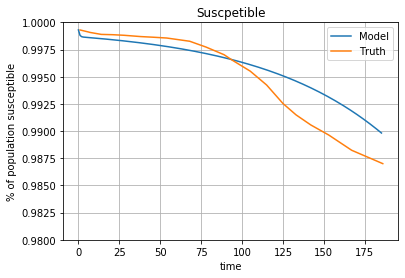

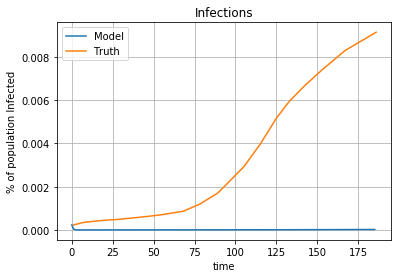

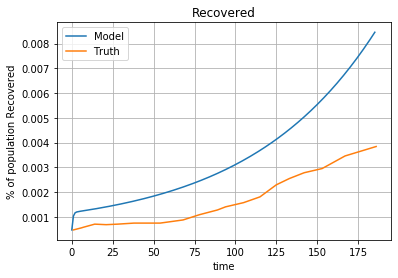

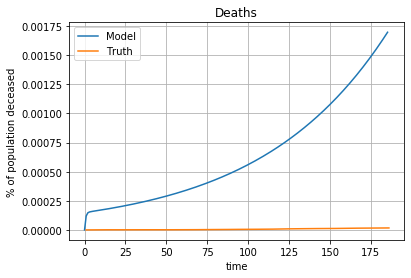

In [18]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.98,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #3

In [19]:
def SIRD_model(y,t,alpha,beta, mu,theta):
    S, I, R, D = y
    dSdt = ((-beta)*S*I) + (theta*S*I) - (c*S*R) - (h*D) 
    dIdt = ((beta)*S*I)  - (theta*S*I) - (alpha*I) - (mu*I) + (c*S*R) + (h*D) 
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [20]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
theta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta ,mu, theta = params['alpha'].value, params['beta'].value, params['mu'].value, params['theta'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, theta)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 39.1188272643197
    print((20-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('theta', value=theta, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

AIC SCORE:
34.05490139767966
AIC SCORE:
34.05490139767966
AIC SCORE:
34.05490139767966
AIC SCORE:
34.0549013611553
AIC SCORE:
34.054901467623864
AIC SCORE:
34.05490140607578
AIC SCORE:
34.05490132773518
AIC SCORE:
12.150933591939959
AIC SCORE:
33.759118846211955
AIC SCORE:
12.153534469866656
AIC SCORE:
32.871672744889615
AIC SCORE:
11.264656107389563
AIC SCORE:
34.32101014102511
AIC SCORE:
34.321010039566985
AIC SCORE:
34.32101032585368
AIC SCORE:
34.3210101508507
AIC SCORE:
34.32100997781492
AIC SCORE:
34.75586870781936
AIC SCORE:
34.755868517478554
AIC SCORE:
34.75586907499845
AIC SCORE:
34.755868710136795
AIC SCORE:
34.75586841554183
AIC SCORE:
35.31956509643682
AIC SCORE:
35.31956513185668
AIC SCORE:
35.31956516757958
AIC SCORE:
35.319565072042664
AIC SCORE:
35.31956504544076
AIC SCORE:
36.09735631931636
AIC SCORE:
36.097355459898594
AIC SCORE:
36.09735732482742
AIC SCORE:
36.09735631443683
AIC SCORE:
36.09735558904946
AIC SCORE:
36.25599824548747
AIC SCORE:
36.255997650469574
AIC 

In [21]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
theta = result.params['theta'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu , "\ntheta =", theta )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, theta  )))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.009180176516717653 
beta = 0.12897255489219717 
mu = 2.105617258330028e-08 
theta = 0.09867196515689125


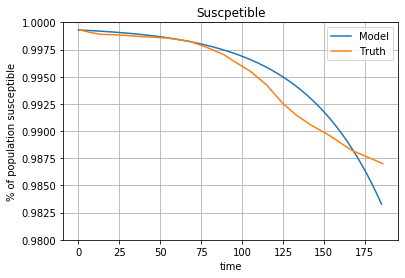

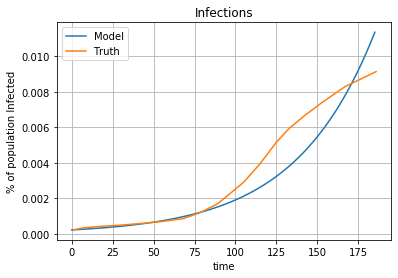

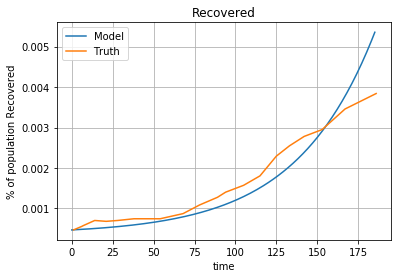

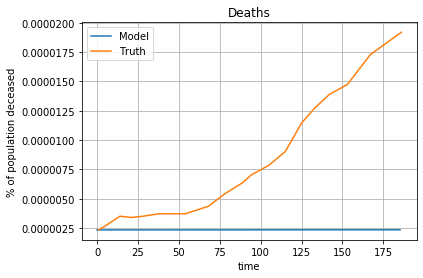

In [22]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### SIRD Model with Control Mechanism #4

In [23]:
def SIRD_model(y,t,alpha,beta, mu, phi):
    S, I, R, D = y
    dSdt = ((-beta)*S*I) - (c*S*R) - (h*D) - phi*(S*I+S*R)
    dIdt = ((beta)*S*I)  - (alpha*I) - (mu*I) + (c*S*R) + (h*D)+ phi*(S*I+S*R)
    dRdt = (alpha*I)
    dDdt = (mu*I)
    
    return dSdt, dIdt, dRdt, dDdt

In [24]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
phi = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tmin=0
tspan = times[tmin:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[tmin:num_days], I_data[tmin:num_days], R_data[tmin:num_days], D_data[tmin:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, phi = params['alpha'].value, params['beta'].value, params['mu'].value, params['phi'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, phi)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    print("AIC SCORE:") #Max: 40.475324296987964
    print((20-2*np.log(sum((sol_1d - data)**2))))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=mu, min=0, max=1)
params.add('phi', value=phi, min=0, max=10)


result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

AIC SCORE:
14.014851618653374
AIC SCORE:
14.014851618653374
AIC SCORE:
14.014851618653374
AIC SCORE:
14.014851710113698
AIC SCORE:
14.014851490053534
AIC SCORE:
14.014851621541558
AIC SCORE:
14.014851396183458
AIC SCORE:
13.190520048463377
AIC SCORE:
13.387933903606083
AIC SCORE:
14.041435889831055
AIC SCORE:
14.041435874915914
AIC SCORE:
14.04143589456076
AIC SCORE:
14.041435895669828
AIC SCORE:
14.041435750890194
AIC SCORE:
14.766848342868727
AIC SCORE:
14.766848305412838
AIC SCORE:
14.766848320640431
AIC SCORE:
14.766848354649166
AIC SCORE:
14.766847822199717
AIC SCORE:
15.66727031669043
AIC SCORE:
15.667270309626005
AIC SCORE:
15.667270537154433
AIC SCORE:
15.667270337810812
AIC SCORE:
15.667269108394137
AIC SCORE:
12.706372113626292
AIC SCORE:
17.405194867826996
AIC SCORE:
17.405194825762848
AIC SCORE:
17.405195197169363
AIC SCORE:
17.405194899590683
AIC SCORE:
17.405192391706834
AIC SCORE:
22.703207651160966
AIC SCORE:
22.70320774435013
AIC SCORE:
22.70320860915873
AIC SCORE:
22.

In [25]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
mu = result.params['mu'].value
phi = result.params['phi'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nmu =", mu ,  "\nphi =", phi  )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, mu, phi  )))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.006800717146659974 
beta = 1.4441231543926847e-09 
mu = 2.8113000816176736e-10 
phi = 0.01690021065448688


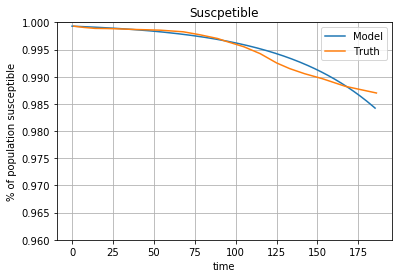

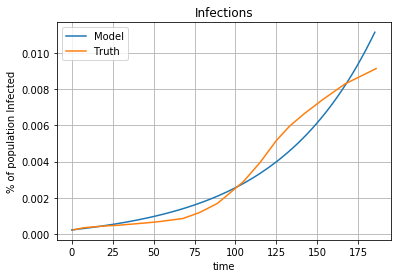

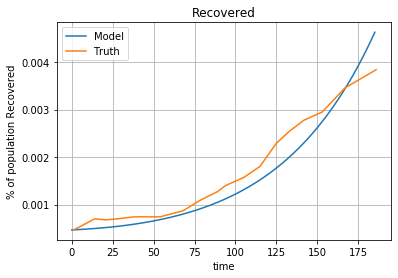

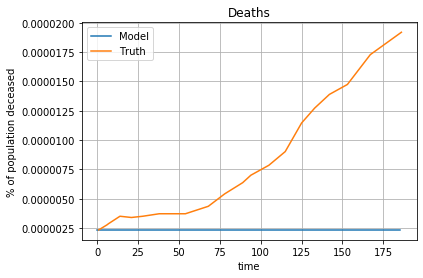

In [26]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:186], S_model[0:186], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.960,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], I_model[0:186], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], R_model[0:186], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:186], D_model[0:186], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()
